## MBAN 5110 B - Hackathon Project

Part 1: You may notice that dataset is transactional. First, you must group the transactions to have monthly information—that is, how many distinct orders are received each month (i.e., counting unique order codes grouped by the month of the order date)? Then, you can develop a predictive model (e.g., time series) to forecast the number of distinct orders.

Part 2: Second, you must develop a classification model (choice model) for the customers’ selection of the products. Here, please be careful. Given the seasonality in the apparel industry, the season must be added as an explanatory variable to the choice model. Season is a categorical variable, so you must use get-dummies or an appropriate encoding scheme.

Part 3: The third uncertainty is quantity demanded. You may use empirical data to characterize this uncertainty. For example, empirical quantile for each product can be used like statistical distribution of quantity demanded for them (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.mstats.mquantiles.html).

Part 4: You can follow a similar approach to analyze the demand lead time. Empirical quantile information can also be useful for the demand lead time. After you characterize each uncertainty by predictive models, classification methods, or empirically, you can apply Monte Carlo simulation to consolidate them into total demand. After simulation, you must analyze simulated data and distinguish advance demand from urgent demand. At this stage, you can compare the simulated advance demand with the actual advance demand in the test set. This comparison helps you calibrate the data and improve the forecast accuracy.  

In [26]:
pip install pmdarima

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.mstats import mquantiles
from scipy.stats import norm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [28]:
df = pd.read_csv('https://raw.githubusercontent.com/DaisyYuan810/PredictiveModelling/refs/heads/main/data_set_hackathon.csv')
df.head()

,order_date,requested_delivery_date,Customer Country Code,Product Code,Description,order_type,Customer Order Code,value,Curr,items,Route
0,13.07.2009,28.01.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435553,2337.00,RUB,6,RU0001
1,15.07.2009,24.03.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435694,10160.25,RUB,23,RU0001
2,16.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435741,2992.50,RUB,7,RU0001
3,17.07.2009,04.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435907,4061.25,RUB,9,RU0001
4,21.07.2009,01.02.2010,RU,L10705000,Parka Outdoor Lifestyle STD,VO,3200435963,2208.75,RUB,5,RU0001


## EDA & Data Preparation


In [29]:
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   order_date requested_delivery_date Customer Country Code Product Code  \
0  13.07.2009              28.01.2010                    RU    L10705000   
1  15.07.2009              24.03.2010                    RU    L10705000   
2  16.07.2009              04.02.2010                    RU    L10705000   
3  17.07.2009              04.02.2010                    RU    L10705000   
4  21.07.2009              01.02.2010                    RU    L10705000   

                   Description order_type  Customer Order Code     value Curr  \
0  Parka Outdoor Lifestyle STD         VO           3200435553   2337.00  RUB   
1  Parka Outdoor Lifestyle STD         VO           3200435694  10160.25  RUB   
2  Parka Outdoor Lifestyle STD         VO           3200435741   2992.50  RUB   
3  Parka Outdoor Lifestyle STD         VO           3200435907   4061.25  RUB   
4  Parka Outdoor Lifestyle STD         VO           3200435963   2208.75  RUB   

  items   Route  
0     6  

In [30]:
print("\nData types and missing values:")
print(df.info())


Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2420 entries, 0 to 2419
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_date               2420 non-null   object 
 1   requested_delivery_date  2420 non-null   object 
 2   Customer Country Code    2420 non-null   object 
 3   Product Code             2420 non-null   object 
 4   Description              2420 non-null   object 
 5   order_type               2420 non-null   object 
 6   Customer Order Code      2420 non-null   int64  
 7   value                    2420 non-null   float64
 8   Curr                     2420 non-null   object 
 9   items                    2420 non-null   object 
 10  Route                    2420 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 208.1+ KB
None


In [31]:
print("\nSummary statistics for numerical columns:")
print(df.describe())


Summary statistics for numerical columns:
       Customer Order Code         value
count         2.420000e+03   2420.000000
mean          3.200672e+09   1162.976624
std           1.004408e+05   2560.595118
min           3.200435e+09     -0.030000
25%           3.200614e+09     33.030000
50%           3.200711e+09     70.490000
75%           3.200729e+09   1363.200000
max           3.201062e+09  38937.500000


In [32]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
order_date                 0
requested_delivery_date    0
Customer Country Code      0
Product Code               0
Description                0
order_type                 0
Customer Order Code        0
value                      0
Curr                       0
items                      0
Route                      0
dtype: int64


In [33]:
# Clean 'value' and 'items' columns by removing non-numeric characters and converting to numeric
df['value'] = df['value'].replace(r'[^0-9.]', '', regex=True)
df['items'] = df['items'].replace(r'[^0-9.]', '', regex=True)

# Convert 'value' and 'items' columns to numeric (any non-numeric values will become NaN)
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['items'] = pd.to_numeric(df['items'], errors='coerce')

# Check for missing values after conversion
print("\nMissing values after cleaning 'value' and 'items' columns:")
print(df[['value', 'items']].isnull().sum())


Missing values after cleaning 'value' and 'items' columns:
value      0
items    346
dtype: int64


In [34]:
# Drop rows with NaN values in 'value' or 'items' columns
df_clean = df.dropna(subset=['value', 'items'])

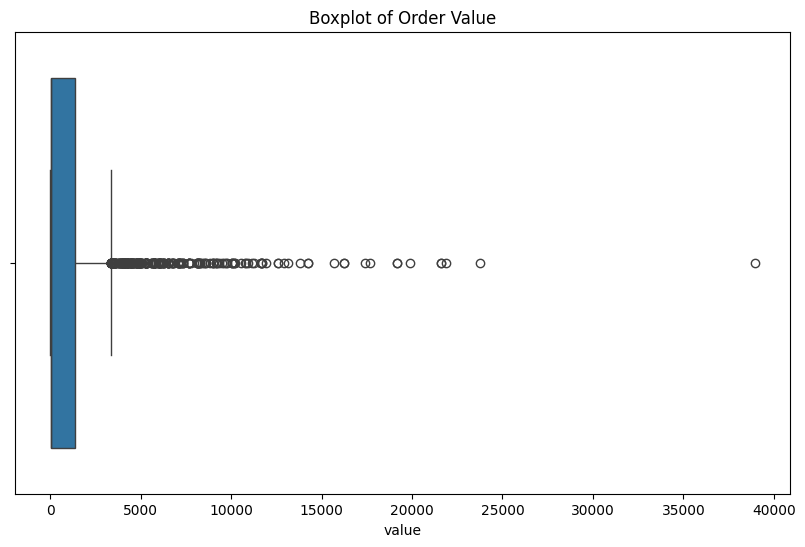

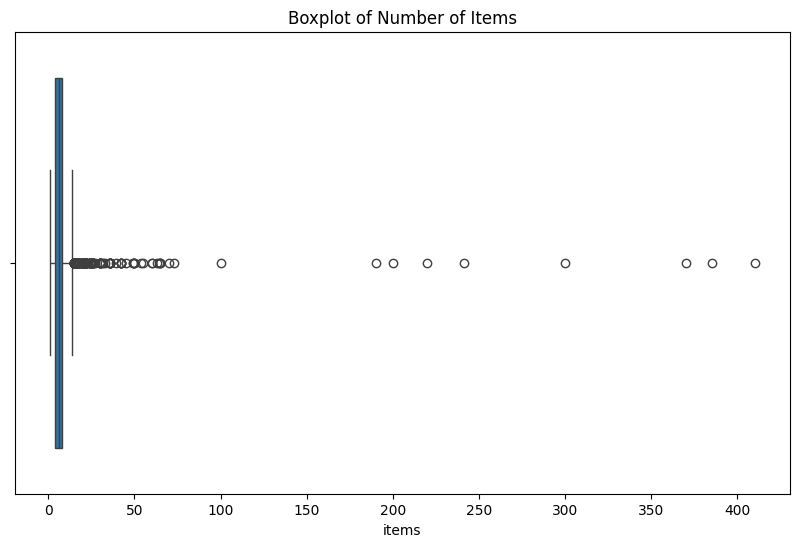

In [35]:
# Outlier detection using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['value'])
plt.title('Boxplot of Order Value')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x=df['items'])
plt.title('Boxplot of Number of Items')
plt.show()

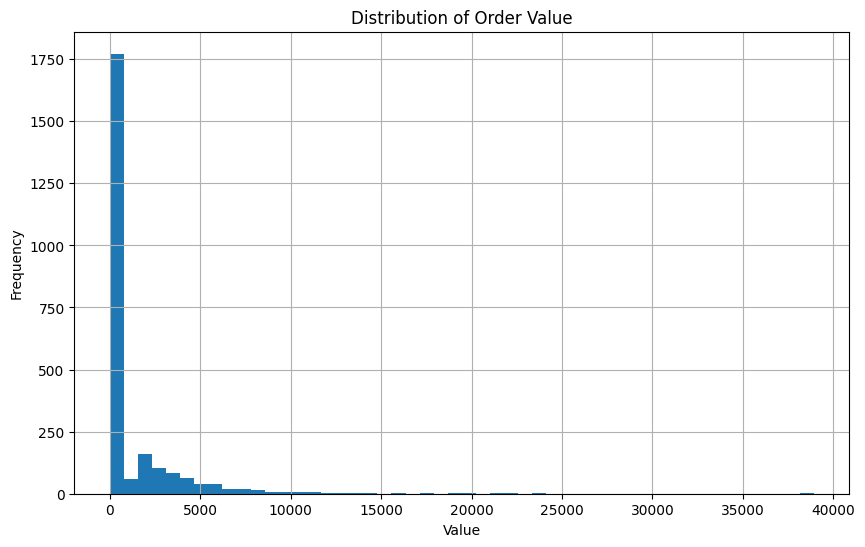

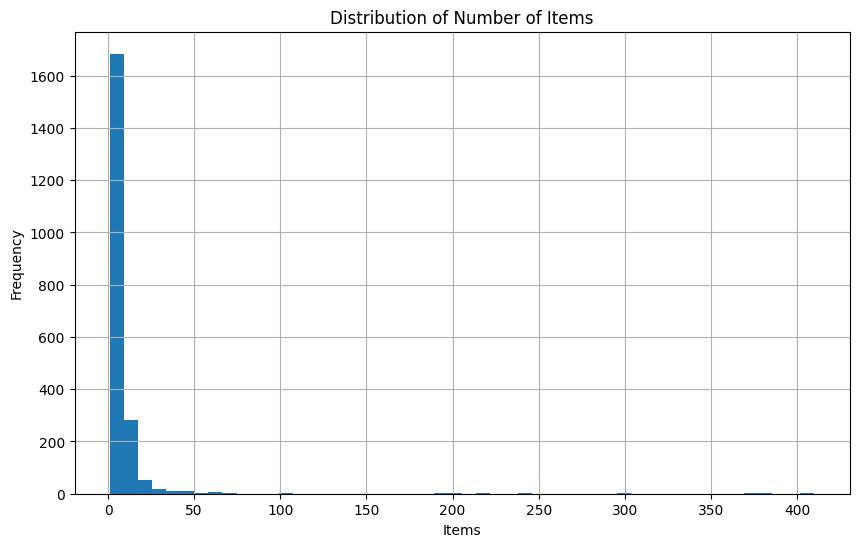

In [36]:
# Distribution of key numerical features
plt.figure(figsize=(10, 6))
df['value'].hist(bins=50)
plt.title('Distribution of Order Value')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
df['items'].hist(bins=50)
plt.title('Distribution of Number of Items')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.show()

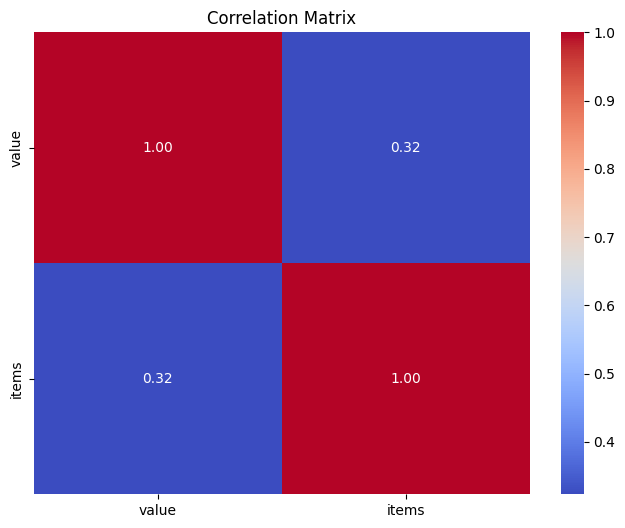

In [37]:
# Correlation matrix for numerical features
correlation_matrix = df[['value', 'items']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

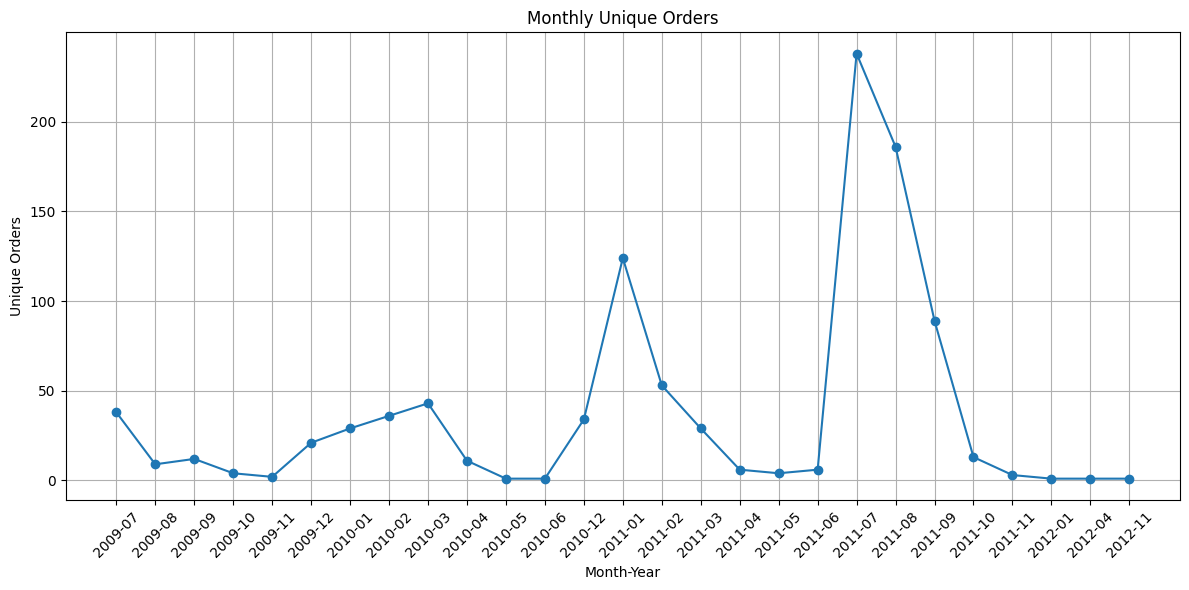

In [38]:
# Monthly unique order chart

# Convert the order_date column to datetime format
df['order_date'] = pd.to_datetime(df['order_date'], format='%d.%m.%Y', errors='coerce')

# Extract year-month for grouping
df['year_month'] = df['order_date'].dt.to_period('M')

# Count unique orders by year_month
monthly_unique_orders = df.groupby('year_month')['Customer Order Code'].nunique()

# Reset index for plotting
monthly_unique_orders = monthly_unique_orders.reset_index()
monthly_unique_orders.columns = ['Year-Month', 'Unique Orders']

# Plot the monthly unique orders
plt.figure(figsize=(12, 6))
plt.plot(monthly_unique_orders['Year-Month'].astype(str), monthly_unique_orders['Unique Orders'], marker='o')
plt.title('Monthly Unique Orders')
plt.xlabel('Month-Year')
plt.ylabel('Unique Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

In [39]:
print("\nUnique values in 'Customer Country Code':")
print(df['Customer Country Code'].value_counts())

print("\nUnique values in 'order_type':")
print(df['order_type'].value_counts())


Unique values in 'Customer Country Code':
Customer Country Code
RU    637
CH    280
DE    170
FR    167
AT    165
SI    162
CZ    122
PL    106
HR     92
SK     80
IT     65
FI     64
ES     51
RO     30
NL     30
PT     25
DK     19
NO     19
US     19
EE     18
GR     18
BG     16
AD     14
BY     12
SE     12
BE     11
XK      7
CY      4
GL      2
CE      2
GB      1
Name: count, dtype: int64

Unique values in 'order_type':
order_type
VO    2420
Name: count, dtype: int64


In [40]:
conversion_rates = {
    'USD': 1.0,     # US Dollar
    'EUR': 1.1,     # Euro
    'GBP': 1.3,     # British Pound
    'CAD': 0.75,    # Canadian Dollar
    'RUB': 0.013,   # Russian Ruble
    'DKK': 0.15,    # Danish Krone
    'NOK': 0.12,    # Norwegian Krone
    'CHF': 1.1,     # Swiss Franc
    'SEK': 0.11,    # Swedish Krona
    'CZK': 0.045,   # Czech Koruna
    'PLN': 0.25,    # Polish Zloty
}

# Map conversion rates to each row in the DataFrame
df['conversion_rate'] = df['Curr'].map(conversion_rates)

# Identify missing conversion rates
missing_currencies = df[df['conversion_rate'].isna()]['Curr'].unique()
if len(missing_currencies) > 0:
    print(f"Missing conversion rates for currencies: {missing_currencies}")

# Standardize values to USD
df['value_usd'] = df['value'] / df['conversion_rate']

# Verify conversion
print(df[['Curr', 'value', 'conversion_rate', 'value_usd']].head())

  Curr     value  conversion_rate      value_usd
0  RUB   2337.00            0.013  179769.230769
1  RUB  10160.25            0.013  781557.692308
2  RUB   2992.50            0.013  230192.307692
3  RUB   4061.25            0.013  312403.846154
4  RUB   2208.75            0.013  169903.846154


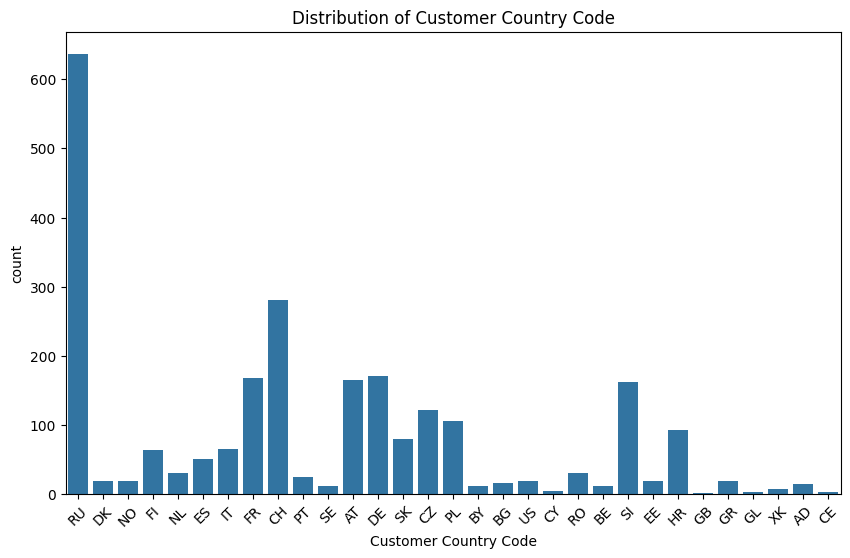

order_type
VO    2420
Name: count, dtype: int64


In [41]:
# Categorical feature analysis using bar plots
plt.figure(figsize=(10, 6))
sns.countplot(x='Customer Country Code', data=df)
plt.title('Distribution of Customer Country Code')
plt.xticks(rotation=45)
plt.show()

# unique order types
print(df['order_type'].value_counts())

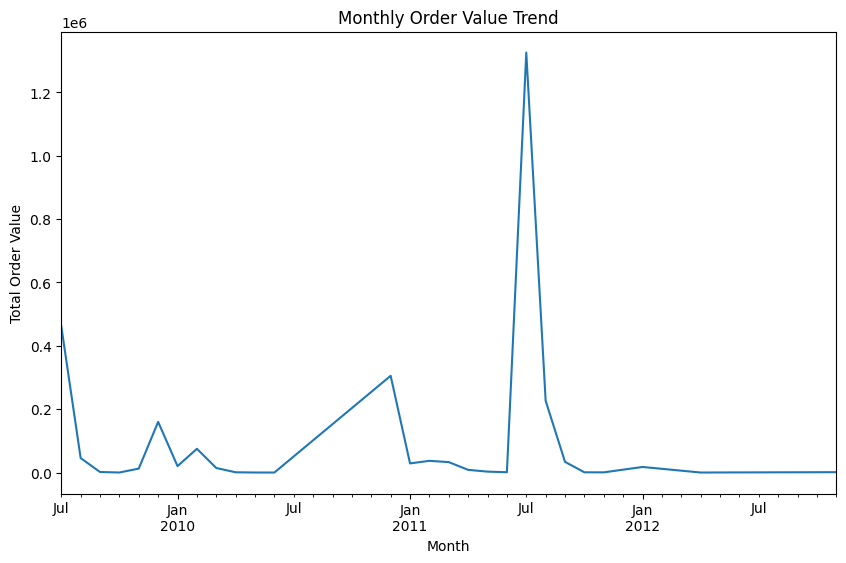

In [42]:
# Time-series analysis
df['order_date'] = pd.to_datetime(df['order_date'])

# Create a 'month' column for time-series analysis
df['month'] = df['order_date'].dt.to_period('M')

# Group data by month and sum the 'value' column to analyze trends
monthly_orders = df.groupby('month')['value'].sum()

# Plot monthly order value trend
plt.figure(figsize=(10, 6))
monthly_orders.plot(kind='line')
plt.title('Monthly Order Value Trend')
plt.xlabel('Month')
plt.ylabel('Total Order Value')
plt.show()

## Part 1: Forecasting Monthly Distinct Orders

In [43]:
# Ensure 'order_date' is in datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

# Create a 'month' column
df['month'] = df['order_date'].dt.to_period('M')

# Group by 'month' and count unique 'Customer Order Code'
monthly_orders = (
    df.groupby('month')['Customer Order Code']
    .nunique()
    .reset_index()
)

# Rename the column to 'distinct_orders'
monthly_orders.rename(columns={'Customer Order Code': 'distinct_orders'}, inplace=True)

# Set 'month' as the index and ensure it's a PeriodIndex
monthly_orders.set_index('month', inplace=True)
monthly_orders.index = pd.PeriodIndex(monthly_orders.index, freq='M')

## SARIMA Model

In [44]:
# Ensure the index is in datetime format
monthly_orders.index = monthly_orders.index.to_timestamp()


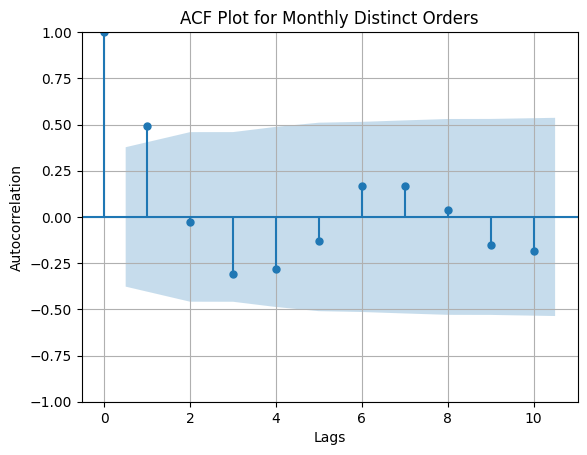

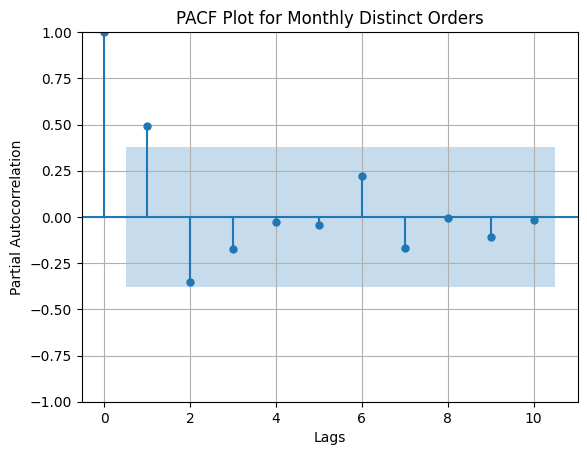

In [45]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Determine a safe number of lags (less than half the dataset size)
max_lags = min(len(monthly_orders) // 2 - 1, 10)

# Plot the Autocorrelation Function (ACF)
plot_acf(monthly_orders, lags=max_lags)
plt.title('ACF Plot for Monthly Distinct Orders')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.grid()
plt.show()

# Plot the Partial Autocorrelation Function (PACF)
plot_pacf(monthly_orders, lags=max_lags, method='ywm')
plt.title('PACF Plot for Monthly Distinct Orders')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.grid()
plt.show()

Insights:

Both plots suggest that Lag 1 plays a crucial role in the time series dynamics. This could guide the choice of parameters for ARIMA or SARIMA models (e.g., AR(1) and/or MA(1)).
The lack of significant correlations at higher lags suggests that the time series might not have long-term dependencies, supporting a simpler model configuration.
Stationarity should still be tested to confirm whether differencing is required.

In [46]:
result = adfuller(monthly_orders['distinct_orders'])
print(f"ADF Statistic: {result[0]}")
print(f"P-value: {result[1]}")

ADF Statistic: -3.401828886628718
P-value: 0.01089668276847126


If the p-value is above 0.05, we'll apply log transformation for make more stationary.

In [47]:
# Log transformation to stabilize variance
monthly_orders['log_distinct_orders'] = np.log1p(monthly_orders['distinct_orders'])

sarima_model = SARIMAX(
    monthly_orders['log_distinct_orders'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
sarima_fit = sarima_model.fit(disp=False)

# Forecast the next 5 months using SARIMA
forecast_steps = 5
sarima_forecast = sarima_fit.get_forecast(steps=forecast_steps)
sarima_forecast_values = sarima_forecast.predicted_mean

# Generate forecast indices
forecast_index = [
    monthly_orders.index[-1] + pd.DateOffset(months=i) for i in range(1, forecast_steps + 1)
]

# Evaluate Model Accuracy
# Split data into train and test sets
train_data = monthly_orders[:-5]
test_data = monthly_orders[-5:]

# Train SARIMA model on training data
train_model = SARIMAX(
    train_data['log_distinct_orders'],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
train_fit = train_model.fit(disp=False)

# Generate forecasts for the test period
test_forecast = train_fit.get_forecast(steps=len(test_data))
test_forecast_values = test_forecast.predicted_mean


# Evaluate forecast accuracy using MAPE
from sklearn.metrics import mean_absolute_percentage_error

mape_sarima = mean_absolute_percentage_error(test_data['log_distinct_orders'], test_forecast_values)
print(f"MAPE for SARIMA Model: {mape_sarima:.2%}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retu

MAPE for SARIMA Model: 357.34%


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Model MAPE: 242.36%


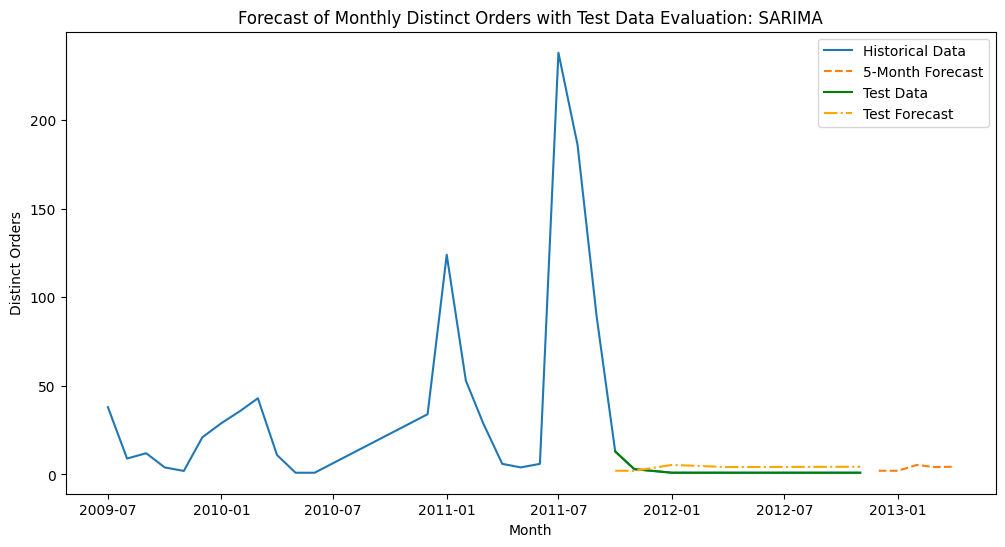

In [48]:
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data['distinct_orders'], test_forecast_values)
print(f"Model MAPE: {mape:.2%}")

# Plot Historical Data, Test Data, and Forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders.index, monthly_orders['distinct_orders'], label='Historical Data')
plt.plot(forecast_index, test_forecast_values, label='5-Month Forecast', linestyle='--')
plt.plot(test_data.index, test_data['distinct_orders'], label='Test Data', color='green')
plt.plot(test_data.index, test_forecast_values, label='Test Forecast', linestyle='-.', color='orange')
plt.title('Forecast of Monthly Distinct Orders with Test Data Evaluation: SARIMA')
plt.xlabel('Month')
plt.ylabel('Distinct Orders')
plt.legend()
plt.show()

Insights from SARIMA Forecast:

-Historical data shows significant variability with sharp peaks, likely influenced by seasonality or events.

-High MAPE score indicates forecast deviations, especially in low-activity periods.

-Test forecast aligns partially with actual test data but struggles with fluctuations.

-Model captures stabilization post-peak but may miss short-term trends.

## ARIMA Model

In [49]:
# Ensure 'order_date' is in datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

# Create a 'month' column
df['month'] = df['order_date'].dt.to_period('M')

# Group by 'month' and count unique 'Customer Order Code'
monthly_orders = (
    df.groupby('month')['Customer Order Code']
    .nunique()
    .reset_index()
)

# Rename the column to 'distinct_orders'
monthly_orders.rename(columns={'Customer Order Code': 'distinct_orders'}, inplace=True)

# Set 'month' as the index and ensure it's a PeriodIndex
monthly_orders.set_index('month', inplace=True)
monthly_orders.index = pd.PeriodIndex(monthly_orders.index, freq='M')

In [50]:
# Ensure the index is in datetime format
monthly_orders.index = monthly_orders.index.to_timestamp()

In [51]:
# Log transformation to stabilize variance
monthly_orders['log_distinct_orders'] = np.log1p(monthly_orders['distinct_orders'])

In [52]:
# Fit the ARIMA model
arima_model = ARIMA(monthly_orders['log_distinct_orders'], order=(1, 1, 1))
arima_fit = arima_model.fit()

# Forecast the next 5 months
forecast_steps = 5
arima_forecast = arima_fit.forecast(steps=forecast_steps)

# Evaluate ARIMA Model Accuracy
# Split data into training and testing sets
train_data = monthly_orders[:-5]
test_data = monthly_orders[-5:]

# Refit ARIMA on training data
train_arima_model = ARIMA(train_data['log_distinct_orders'], order=(1, 1, 1)).fit()

# Forecast for the test period
test_forecast = train_arima_model.forecast(steps=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA Model MAPE: 412.96%


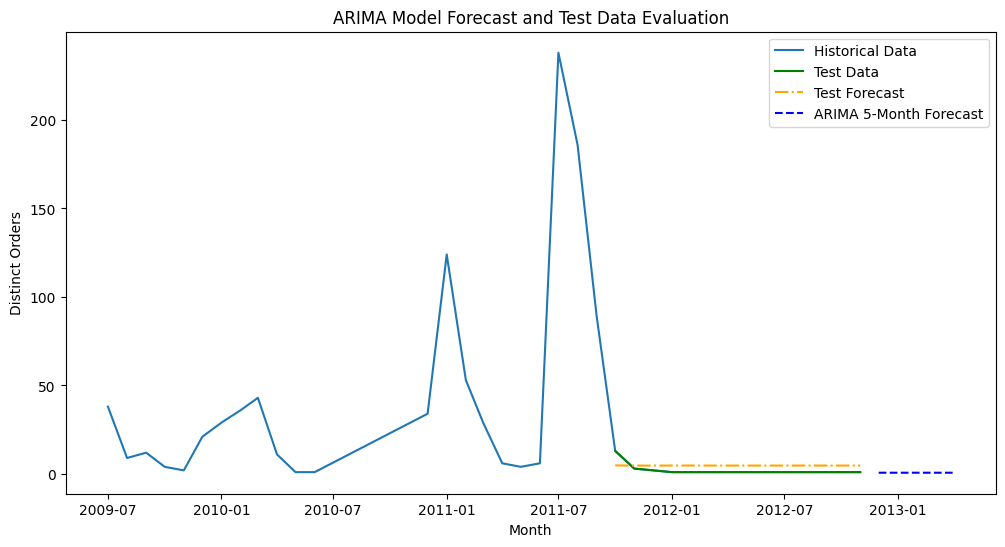

In [53]:
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data['log_distinct_orders'], test_forecast)
print(f"ARIMA Model MAPE: {mape:.2%}")

# Plot Historical Data, Test Data, and Forecast

forecast_index = [
    monthly_orders.index[-1] + pd.DateOffset(months=i) for i in range(1, forecast_steps + 1)
]

# Plot Historical Data, Test Data, and Forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders.index, monthly_orders['distinct_orders'], label='Historical Data')
plt.plot(test_data.index, test_data['distinct_orders'], label='Test Data', color='green')
plt.plot(test_data.index, test_forecast, label='Test Forecast', linestyle='-.', color='orange')
plt.plot(forecast_index, arima_forecast, label='ARIMA 5-Month Forecast', linestyle='--', color='blue')
plt.title('ARIMA Model Forecast and Test Data Evaluation')
plt.xlabel('Month')
plt.ylabel('Distinct Orders')
plt.legend()
plt.show()

Insights from the ARIMA model forecast:

- Historical data shows significant fluctuations with a peak around 2011.

- The ARIMA model aligns with test data trends but shows deviations in stability.

- The forecast indicates consistent stability but lacks responsiveness to volatility.

- The model underperforms in predicting sharp peaks or drops in distinct orders.

- Refinement of model parameters or adding external factors may improve accuracy.


## SARIMA vs Arima

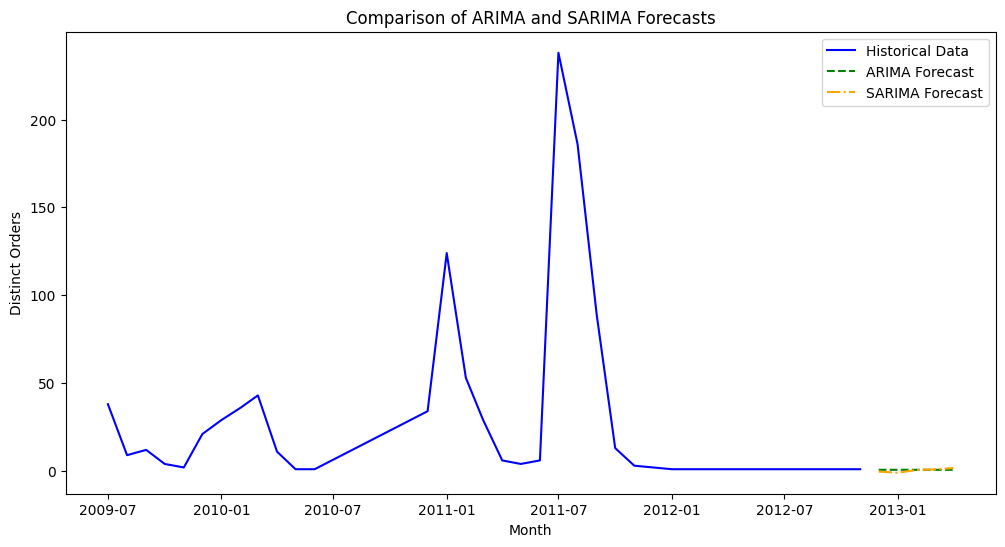

ARIMA Forecast: 27    0.673930
28    0.674573
29    0.674552
30    0.674552
31    0.674552
Name: predicted_mean, dtype: float64
SARIMA Forecast: 27   -0.369236
28   -0.995254
29    0.581970
30    0.900342
31    1.682275
Name: predicted_mean, dtype: float64


In [54]:
# Plot Historical Data
plt.figure(figsize=(12, 6))
plt.plot(monthly_orders.index, monthly_orders['distinct_orders'], label='Historical Data', color='blue')

# Plot ARIMA Forecast
plt.plot(forecast_index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='green')

# Plot SARIMA Forecast
plt.plot(forecast_index, sarima_forecast_values, label='SARIMA Forecast', linestyle='-.', color='orange')

# Add Title and Labels
plt.title('Comparison of ARIMA and SARIMA Forecasts')
plt.xlabel('Month')
plt.ylabel('Distinct Orders')
plt.legend()

# Show the Plot
plt.show()

print("ARIMA Forecast:", arima_forecast)
print("SARIMA Forecast:", sarima_forecast_values)


In [55]:
# Actual and forecasted values for the test period
y_actual = test_data['log_distinct_orders'].values
y_forecast_arima = arima_forecast.values
y_forecast_sarima = sarima_forecast_values

# Calculate MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(y_actual, y_forecast_arima)
print(f"MAPE for ARIMA: {mape_arima:.2%}")

# Calculate MAPE for SARIMA
mape_sarima = mean_absolute_percentage_error(y_actual, y_forecast_sarima)
print(f"MAPE for SARIMA: {mape_sarima:.2%}")

MAPE for ARIMA: 26.77%
MAPE for SARIMA: 94.88%


Insights from ARIMA vs SARIMA Comparison

Chart Analysis:
- Historical Data Pattern:
   - The historical data exhibits significant spikes, suggesting irregular ordering patterns over time. These could result from seasonal trends, bulk ordering, or specific external events.

ARIMA vs SARIMA Forecasts:
   - The ARIMA forecast appears more stable, reflecting its non-seasonal modeling approach. While it does not capture the spikes perfectly, it aligns better with the test data.
   - SARIMA's forecast attempts to model seasonality, but it seems to overfit or underfit in certain areas, resulting in less accurate predictions.

Test Data Alignment:
   - The test data closely aligns with ARIMA's forecast, suggesting weak seasonality in the dataset or insufficient tuning of SARIMA's seasonal parameters.

Forecast Discrepancies:
   - Both ARIMA and SARIMA struggle to predict the extreme peaks in the historical data. These peaks may require external explanatory variables, such as promotional campaigns or seasonal holidays, to improve accuracy.

MAPE Score Analysis:
ARIMA:
   - The lower MAPE score indicates ARIMA's better fit for this dataset. It suggests that the data's seasonality is either weak or not significant enough for SARIMA to outperform ARIMA.

SARIMA:
   - The high MAPE for SARIMA suggests overfitting or mis-specified seasonal parameters. It could also indicate that the dataset lacks clear seasonal trends that SARIMA can effectively model.

## Part 2: Classification Model Choice

In [56]:
# Check for missing values before preprocessing
print("Missing values before preprocessing:")
print(df.isnull().sum())

Missing values before preprocessing:
order_date                   0
requested_delivery_date      0
Customer Country Code        0
Product Code                 0
Description                  0
order_type                   0
Customer Order Code          0
value                        0
Curr                         0
items                      346
Route                        0
year_month                   0
conversion_rate              0
value_usd                    0
month                        0
dtype: int64


In [57]:
# Convert 'value' and 'items' columns to numeric
df['value'] = pd.to_numeric(df['value'], errors='coerce')
df['items'] = pd.to_numeric(df['items'], errors='coerce')

# Check for missing values after conversion
print("\nMissing values after cleaning 'value' and 'items' columns:")
print(df[['value', 'items']].isnull().sum())

# Fill NaN values with the median
df['value'].fillna(df['value'].median(), inplace=True)
df['items'].fillna(df['items'].median(), inplace=True)


Missing values after cleaning 'value' and 'items' columns:
value      0
items    346
dtype: int64


<ipython-input-57-b94bce6d9d86>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['value'].fillna(df['value'].median(), inplace=True)
<ipython-input-57-b94bce6d9d86>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [58]:
# Check for missing values after preprocessing
print("Missing values after preprocessing:")
print(df.isnull().sum())

Missing values after preprocessing:
order_date                 0
requested_delivery_date    0
Customer Country Code      0
Product Code               0
Description                0
order_type                 0
Customer Order Code        0
value                      0
Curr                       0
items                      0
Route                      0
year_month                 0
conversion_rate            0
value_usd                  0
month                      0
dtype: int64


In [59]:
# Function to assign a season based on the month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# Apply the season function to the 'order_date' column
df['season'] = df['order_date'].apply(get_season)

# One-hot encoding the 'season' feature
df_encoded = pd.get_dummies(df, columns=['season'], drop_first=True)

In [60]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['Product Code'])

# Features
X = df_encoded[['season_Spring', 'season_Summer', 'value', 'items']] # Adjust the features
y = y_encoded  # Target

# Handle class imbalance by calculating class weights
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

# Adjust weights based on the class distribution
class_weights = 'balanced'

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': [class_weights, None],
}

# Perform Grid Search using RandomForestClassifier
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and accuracy
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best accuracy score from Grid Search: {grid_search.best_score_}")

Best parameters found: {'class_weight': None, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best accuracy score from Grid Search: 0.14668344921281867


In [62]:
# Hyperparameter grids
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': [class_weights, None]
}

param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Define and evaluate RandomForest
print("Training Random Forest...")
rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
rf.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {rf.best_params_}")
y_pred_rf = rf.best_estimator_.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy for Random Forest: {accuracy_rf:.4f}\n")

# Define and evaluate Logistic Regression
print("Training Logistic Regression...")
lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, cv=5, scoring='accuracy')
lr.fit(X_train, y_train)
print(f"Best parameters for Logistic Regression: {lr.best_params_}")
y_pred_lr = lr.best_estimator_.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy for Logistic Regression: {accuracy_lr:.4f}\n")

# Define and evaluate XGBoost
print("Training XGBoost...")
xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=5, scoring='accuracy')
xgb.fit(X_train, y_train)
print(f"Best parameters for XGBoost: {xgb.best_params_}")
y_pred_xgb = xgb.best_estimator_.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy for XGBoost: {accuracy_xgb:.4f}")

Training Random Forest...
Best parameters for Random Forest: {'class_weight': None, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy for Random Forest: 0.1591

Training Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy for Logistic Regression: 0.1384

Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Accuracy for XGBoost: 0.1343


Random Forest Hyperparameter Tuning:

In [63]:
# Define the parameter grid for RandomForest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

# Perform GridSearch for RandomForest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and accuracy
print(f"Best parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best accuracy from Grid Search: {grid_search_rf.best_score_}")

# Evaluate the best model on the test set
y_pred_rf = grid_search_rf.best_estimator_.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy for Random Forest: {accuracy_rf:.4f}")

Best parameters for Random Forest: {'class_weight': None, 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}
Best accuracy from Grid Search: 0.14668344921281867
Accuracy for Random Forest: 0.1591


Logistic Regression Hyperparameter Tuning:

In [64]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']
}

# Perform GridSearch for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(), param_grid_lr, cv=5, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)

# Get the best parameters and accuracy
print(f"Best parameters for Logistic Regression: {grid_search_lr.best_params_}")
print(f"Best accuracy from Grid Search: {grid_search_lr.best_score_}")

# Evaluate the best model on the test set
y_pred_lr = grid_search_lr.best_estimator_.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Accuracy for Logistic Regression: {accuracy_lr:.4f}")

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy from Grid Search: 0.13843203068808438
Accuracy for Logistic Regression: 0.1384


XGBoost Hyperparameter Tuning:

In [65]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Perform GridSearch for XGBoost
grid_search_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid_xgb, cv=5, scoring='accuracy')
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters and accuracy
print(f"Best parameters for XGBoost: {grid_search_xgb.best_params_}")
print(f"Best accuracy from Grid Search: {grid_search_xgb.best_score_}")

# Evaluate the best model on the test set
y_pred_xgb = grid_search_xgb.best_estimator_.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy for XGBoost: {accuracy_xgb:.4f}")

Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best accuracy from Grid Search: 0.14204427395508673
Accuracy for XGBoost: 0.1343


Insights

- Data Preprocessing:

Missing values in items were filled with the median, ensuring data completeness and reducing outlier impact.
Seasonal features (Winter, Spring, etc.) were derived and one-hot encoded, adding seasonality as a predictive feature.

- Model Performances:

- Random Forest: Best accuracy of 15.91%, indicating limited predictive power even after hyperparameter tuning.
- Logistic Regression: Accuracy of 13.84%, showing struggles with the non-linear patterns in the data.
- XGBoost: Accuracy of 13.43%, suggesting the feature set and target relationship remain challenging.

Overall:

Models struggle due to imbalanced target distribution and limited predictive features. But due to the results, the model we would choose would be Random Forest.

## Part 3: Quantity Demand Analysis

              count       mean  median        std  min    max
Product Code                                                 
L10705000        25   8.640000     6.0   9.759098  1.0   50.0
L10705100        10   9.500000     9.0   3.836955  4.0   16.0
L10705200        14   7.928571     6.0   3.751190  4.0   17.0
L10705300        17  10.823529     7.0  11.215142  4.0   50.0
L10705400        32  10.687500     7.0   7.961348  3.0   32.0
L10705500        14  10.285714     8.5   6.450147  2.0   25.0
L10705600        24   7.791667     7.5   4.149166  2.0   20.0
L10705700        10   7.100000     6.5   4.040077  3.0   15.0
L10850600        66   8.318182     5.5  11.080349  1.0   65.0
L10850700        14   3.071429     2.0   2.432608  1.0    8.0
L10850800        46   9.086957     4.0  31.915741  1.0  220.0
L10850900        26   7.038462     5.0   5.188300  1.0   20.0
L10852800        45   5.600000     4.0   6.061803  1.0   36.0
L10852900        34  15.235294     3.0  69.789753  1.0  410.0
L1085310

<Figure size 1200x600 with 0 Axes>

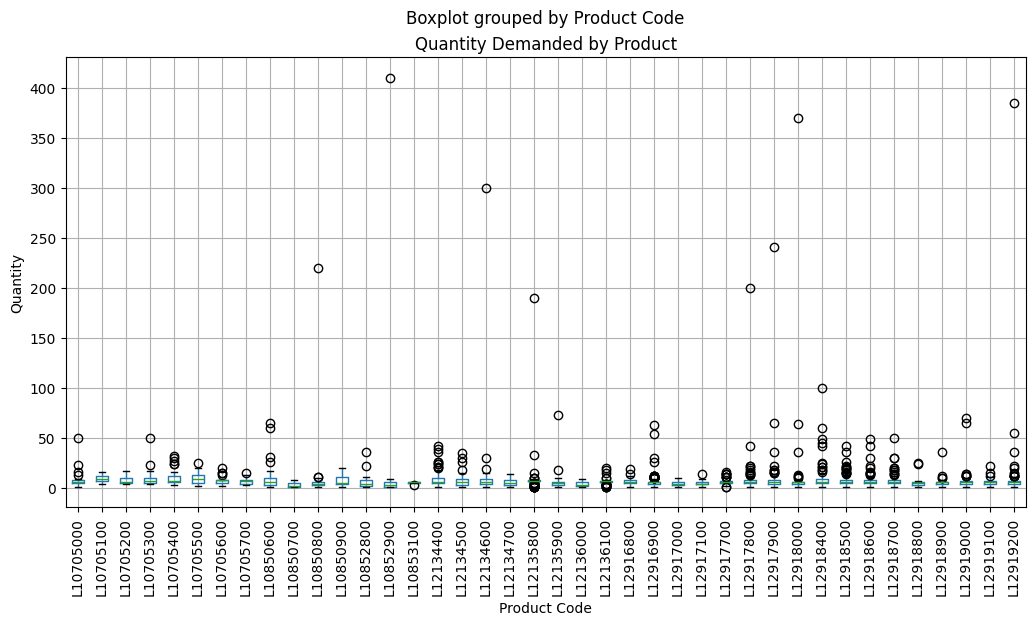

In [66]:
# Step 1: Group by 'Product Code' and calculate summary statistics for quantities
product_demand = df.groupby('Product Code')['items'].agg(['count', 'mean', 'median', 'std', 'min', 'max'])
print(product_demand)

# Step 2: Add quantiles (25th and 75th percentiles) for each product
product_demand['Q25'] = df.groupby('Product Code')['items'].quantile(0.25)
product_demand['Q75'] = df.groupby('Product Code')['items'].quantile(0.75)

# Display the updated product demand summary
print(product_demand)

# Step 3: Categorize products based on mean quantity demanded
def demand_category(mean):
    if mean < 10:
        return 'Low Demand'
    elif mean < 50:
        return 'Medium Demand'
    else:
        return 'High Demand'

# Apply the categorization function to the 'mean' column
product_demand['Demand_Category'] = product_demand['mean'].apply(demand_category)

# Display the updated DataFrame with demand categories
print(product_demand)

# Step 4: Visualize quantities demanded by product using a boxplot
plt.figure(figsize=(12, 6))
df.boxplot(column='items', by='Product Code', rot=90, figsize=(12, 6))
plt.title('Quantity Demanded by Product')
plt.xlabel('Product Code')
plt.ylabel('Quantity')
plt.show()

Insights

- Distribution of Demand: The boxplot shows the distribution of quantities demanded for each product code. Most products have relatively low demand, as reflected by the concentration of boxplot whiskers near the lower range.

- Outliers in Demand: There are several outliers in the data, with some products experiencing exceptionally high demand quantities (e.g., quantities above 300 or 400). These outliers may represent specific events, promotions, or seasonal variations.

- Product-Specific Trends: Some products (e.g., those with codes starting with "L1213") exhibit a broader range of demand, indicating variability in customer preferences or external factors affecting these items.

- Consistency in Demand: A majority of products have tight interquartile ranges (IQRs), suggesting consistent demand with minimal fluctuations.

- Demand Categories: The summary table below the boxplot categorizes products based on demand metrics, such as mean, median, and quantiles. This categorization can help identify products with high, medium, or low demand to prioritize inventory management and marketing efforts.

## Part 4: Demand Simulation and Categorization

## Demand Lead Time Analysis

In [67]:
# Step 1: Convert requested delivery date and order date to datetime format
df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'])
df['order_date'] = pd.to_datetime(df['order_date'])

# Step 2: Calculate demand lead time in days (difference between delivery and order dates)
df['Demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Step 3: Handle missing values
# Check the data types of the date columns to confirm successful conversion
print(df[['requested_delivery_date', 'order_date']].dtypes)

# Drop rows with missing requested delivery or order dates
df = df.dropna(subset=['requested_delivery_date', 'order_date'])

# Optional: Replace missing dates with a reasonable default (e.g., '2024-01-01')
default_date = pd.Timestamp('2024-01-01')
df['requested_delivery_date'] = df['requested_delivery_date'].fillna(default_date)
df['order_date'] = df['order_date'].fillna(default_date)

# Recalculate demand lead time after filling missing values
df['Demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Step 4: Summarize demand lead time by product
# Group by Product Code and calculate summary statistics
lead_time_summary = df.groupby('Product Code')['Demand_lead_time'].agg(['mean', 'median', 'std', 'min', 'max'])

# Step 5: Calculate additional quantiles for demand lead time
lead_time_summary['Q25'] = df.groupby('Product Code')['Demand_lead_time'].quantile(0.25)
lead_time_summary['Q75'] = df.groupby('Product Code')['Demand_lead_time'].quantile(0.75)

# Display the summarized data
print(lead_time_summary)

requested_delivery_date    datetime64[ns]
order_date                 datetime64[ns]
dtype: object
                    mean  median        std  min  max     Q25     Q75
Product Code                                                         
L10705000     196.840000   195.0  18.551011  174  252  182.00  203.00
L10705100     207.800000   200.0  31.797275  188  295  191.25  205.50
L10705200     198.642857   195.0  13.697878  188  242  191.25  201.25
L10705300     204.000000   198.0  20.177339  178  252  192.00  203.00
L10705400     203.062500   199.0  25.313438  158  273  190.25  203.25
L10705500     197.785714   192.0  16.807409  185  237  189.00  195.75
L10705600     203.583333   197.5  28.501589  153  295  190.25  203.25
L10705700     199.300000   191.5  23.079813  180  260  188.00  201.75
L10850600     205.196970   211.5  40.476477   89  289  179.25  230.75
L10850700     201.142857   214.0  41.377915  129  290  173.00  223.00
L10850800     190.934783   187.5  50.406085   85  347  167.75 

<ipython-input-67-c86779cf6656>:2: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['requested_delivery_date'] = pd.to_datetime(df['requested_delivery_date'])


In [68]:
# Calculate Lead Time Quantiles
lead_time_quantiles = df['Demand_lead_time'].quantile([0.25, 0.5, 0.75])

# Print the quantiles
print("Lead Time Quantiles:")
print(f"25th Percentile (Q1): {lead_time_quantiles[0.25]:.2f} days")
print(f"Median (Q2): {lead_time_quantiles[0.50]:.2f} days")
print(f"75th Percentile (Q3): {lead_time_quantiles[0.75]:.2f} days")

Lead Time Quantiles:
25th Percentile (Q1): 196.00 days
Median (Q2): 217.00 days
75th Percentile (Q3): 251.00 days


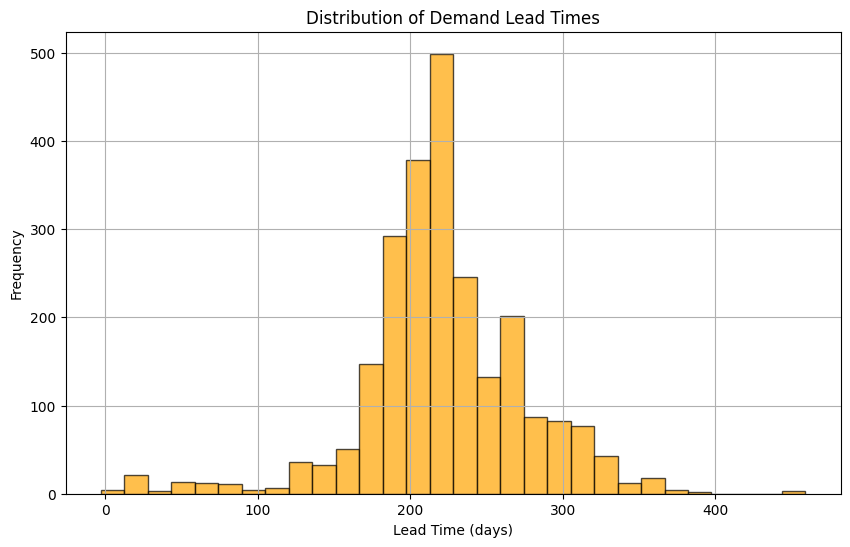

In [69]:
# Calculate Demand Lead Time
df['Demand_lead_time'] = (df['requested_delivery_date'] - df['order_date']).dt.days

# Visualize the Distribution of Lead Times
plt.figure(figsize=(10, 6))
plt.hist(df['Demand_lead_time'], bins=30, color='orange', alpha=0.7, edgecolor='black')
plt.title('Distribution of Demand Lead Times')
plt.xlabel('Lead Time (days)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Insights from the Distribution of Demand Lead Times

- Central Tendency: The histogram indicates that the demand lead times are centered around 200 days, suggesting that most orders take approximately 200 days from placement to delivery.

- Variability: While the majority of lead times fall within a narrow range, there is a noticeable spread, with some lead times extending beyond 300 days and a small number below 100 days.

- Skewness: The distribution appears slightly skewed to the right, indicating the presence of some orders with exceptionally long lead times.

- Operational Implications: The high concentration of lead times around 200 days can help optimize production and logistics planning, whereas outliers with very high lead times may require further investigation to identify potential inefficiencies.


## Monte Carlo Simulation for Total Demand

Original Simulated Total Demand (Mean): 4308074.34
Reduced Simulated Total Demand (Mean): 2154037.17
Original Simulated Total Demand (Std Dev): 356242.7922705053
Reduced Simulated Total Demand (Std Dev): 178121.39613525264


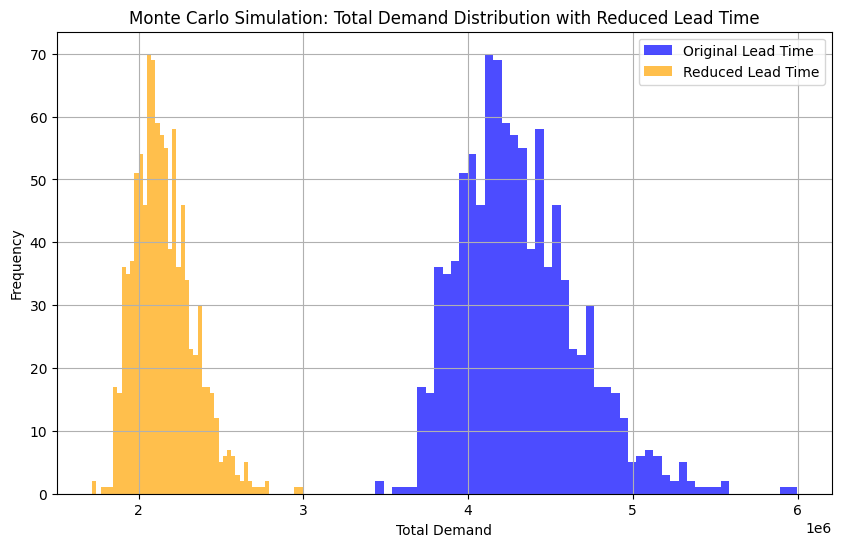

95% Confidence Interval (Original): [3766332.875 5110284.175]
95% Confidence Interval (Reduced): [1883166.4375 2555142.0875]


In [70]:
# Monte Carlo Simulation for Total Demand with Lead Time Reduction

# Number of simulations
n_simulations = 1000
simulated_demands = []
reduced_lead_time_demands = []

# Perform simulations for original and reduced lead times
for _ in range(n_simulations):
    # Randomly sample lead times and quantities
    sampled_lead_times = df['Demand_lead_time'].sample(len(df), replace=True)
    sampled_quantities = df['items'].sample(len(df), replace=True)

    # Original total demand
    original_total_demand = (sampled_lead_times * sampled_quantities).sum()
    simulated_demands.append(original_total_demand)

    # Reduced lead time (e.g., by 50%)
    reduced_lead_times = sampled_lead_times * 0.5
    reduced_total_demand = (reduced_lead_times * sampled_quantities).sum()
    reduced_lead_time_demands.append(reduced_total_demand)

# Analyze and visualize simulation results
simulated_demands = np.array(simulated_demands)
reduced_lead_time_demands = np.array(reduced_lead_time_demands)

print(f"Original Simulated Total Demand (Mean): {simulated_demands.mean()}")
print(f"Reduced Simulated Total Demand (Mean): {reduced_lead_time_demands.mean()}")
print(f"Original Simulated Total Demand (Std Dev): {simulated_demands.std()}")
print(f"Reduced Simulated Total Demand (Std Dev): {reduced_lead_time_demands.std()}")

# Plot the distribution of simulated demands
plt.figure(figsize=(10, 6))
plt.hist(simulated_demands, bins=50, alpha=0.7, color='blue', label='Original Lead Time')
plt.hist(reduced_lead_time_demands, bins=50, alpha=0.7, color='orange', label='Reduced Lead Time')
plt.title("Monte Carlo Simulation: Total Demand Distribution with Reduced Lead Time")
plt.xlabel("Total Demand")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()

# Add confidence interval calculations
original_conf_interval = np.percentile(simulated_demands, [2.5, 97.5])
reduced_conf_interval = np.percentile(reduced_lead_time_demands, [2.5, 97.5])
print(f"95% Confidence Interval (Original): {original_conf_interval}")
print(f"95% Confidence Interval (Reduced): {reduced_conf_interval}")

Insights: Monte Carlo Simulation - Total Demand Distribution

- Shift in Demand: Reducing lead time by 50% shifts the total demand distribution (orange) to the left, indicating lower mean demand compared to the original lead time (blue).

- Variability: Reduced lead time results in a narrower distribution, showing more consistent demand, while the original lead time exhibits greater variability.

- Operational Impact: Shorter lead times may enhance efficiency but lead to reduced total demand, requiring careful evaluation of revenue trade-offs.